In [62]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd

from src.preprocess.text import SentenceGetter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize

from tqdm.notebook import tqdm

from itertools import chain

import matplotlib.pyplot as plt

from sklearn.metrics import precision_recall_fscore_support, confusion_matrix

from src.preprocess.text import sent2features, sent2labels

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, concatenate, SpatialDropout1D, Conv1D, MaxPooling1D, Flatten
from tensorflow_addons.layers import CRF

from tf2crf import ModelWithCRFLoss
import tensorflow.keras as k

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
ner_dataset = pd.read_csv("/Users/Mikhail_Bulgakov/GitRepo/pos_ner_task/data/ner_dataset.csv", delimiter=',', encoding='unicode_escape')
ner_dataset = ner_dataset.fillna(method="ffill")

In [3]:
sg = SentenceGetter(ner_dataset)

In [4]:
train_data, test_data = train_test_split(sg.get_full_data(), test_size=0.2, random_state=100)

In [5]:
words = list(set([i[0] for i in chain.from_iterable(train_data)]))
words.append("ENDPAD")
words.append("UNKNOWN")

n_words = len(words)

tags = list(set([i[2] for i in chain.from_iterable(train_data)]))
n_tags = len(tags)

In [6]:
max_len = 50
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [7]:
word2idx["Obama"]

6123

In [8]:
word2idx["UNKNOWN"]

31936

In [9]:
tag2idx["B-geo"]

0

In [10]:
X = [[word2idx[w[0]] for w in s] for s in train_data]
print(len(X))
print(len(X[0]))

38367
32


In [11]:
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=n_words - 1)
X.shape

(38367, 50)

In [12]:
y = [[tag2idx[w[2]] for w in s] for s in train_data]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])
y = [to_categorical(i, num_classes=n_tags) for i in y]

Model Simple

In [58]:
input = Input(shape=(max_len,))
model = Embedding(input_dim=n_words, output_dim=50, input_length=max_len)(input)  # 50-dim embedding
model = Dropout(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)  # variational biLSTM
out = TimeDistributed(Dense(n_tags, activation="softmax"))(model)  # softmax output layer

In [59]:
model = Model(input, out)

In [60]:
model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy", tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall")])

In [61]:
history = model.fit(X, np.array(y), batch_size=1024, epochs=5, validation_split=0.1, verbose=1)

Epoch 1/5
34/34 [==============================] - 17s 404ms/step - loss: 0.6235 - accuracy: 0.9060 - precision: 0.9332 - recall: 0.8223 - val_loss: 0.3389 - val_accuracy: 0.9326 - val_precision: 0.9326 - val_recall: 0.9326
Epoch 2/5
34/34 [==============================] - 13s 385ms/step - loss: 0.3232 - accuracy: 0.9331 - precision: 0.9332 - recall: 0.9328 - val_loss: 0.3022 - val_accuracy: 0.9326 - val_precision: 0.9327 - val_recall: 0.9322
Epoch 3/5
34/34 [==============================] - 13s 387ms/step - loss: 0.2661 - accuracy: 0.9331 - precision: 0.9458 - recall: 0.9321 - val_loss: 0.2302 - val_accuracy: 0.9328 - val_precision: 0.9790 - val_recall: 0.9296
Epoch 4/5
34/34 [==============================] - 13s 381ms/step - loss: 0.1955 - accuracy: 0.9408 - precision: 0.9833 - recall: 0.9303 - val_loss: 0.1734 - val_accuracy: 0.9473 - val_precision: 0.9887 - val_recall: 0.9293
Epoch 5/5
34/34 [==============================] - 12s 364ms/step - loss: 0.1555 - accuracy: 0.9506 - pr

In [62]:
hist = pd.DataFrame(history.history)
hist

,loss,accuracy,precision,recall,val_loss,val_accuracy,val_precision,val_recall
0,0.623542,0.906038,0.933196,0.822297,0.338907,0.932588,0.932588,0.932588
1,0.323202,0.933099,0.933165,0.932778,0.302202,0.932588,0.932724,0.932223
2,0.266069,0.933101,0.945848,0.932106,0.230220,0.932786,0.978993,0.929643
3,0.195515,0.940828,0.983298,0.930285,0.173389,0.947313,0.988704,0.929309
4,0.155468,0.950626,0.991562,0.930239,0.145213,0.952635,0.991066,0.930925


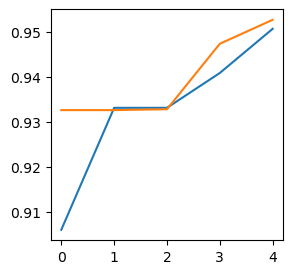

In [63]:
plt.figure(figsize=(3,3))
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])
plt.show()

In [28]:
X_test = [[word2idx.get(w[0], word2idx["UNKNOWN"]) for w in s] for s in test_data]
X_test = pad_sequences(maxlen=max_len, sequences=X_test, padding="post", value=n_words - 1)

In [33]:
y_test = [[tag2idx[w[2]] for w in s] for s in test_data]
y_test = pad_sequences(maxlen=max_len, sequences=y_test, padding="post", value=tag2idx["O"])
y_test = [tags[i] for i in list(chain.from_iterable(y_test))]

In [89]:
y_pred = [tags[i] for i in list(chain.from_iterable(np.argmax(model.predict(X_test),axis=-1)))]

300/300 [==============================] - 3s 10ms/step


In [35]:
states = list(set([i[2] for i in chain.from_iterable(train_data)]))

In [97]:
df = pd.DataFrame(confusion_matrix(y_test, y_pred, labels=states), index=states, columns=states)
df = df.reindex(sorted(df.columns), axis=1).sort_index()
df

,B-art,B-eve,B-geo,B-gpe,B-nat,B-org,B-per,B-tim,I-art,I-eve,I-geo,I-gpe,I-nat,I-org,I-per,I-tim,O
B-art,0,0,26,0,0,5,2,0,0,0,0,0,0,1,1,0,43
B-eve,0,0,23,0,0,2,3,0,0,0,0,0,0,4,0,0,30
B-geo,0,0,5877,0,0,172,365,2,0,0,1,0,0,42,387,0,838
B-gpe,0,0,2198,0,0,78,341,2,0,0,0,0,0,39,361,0,87
B-nat,0,0,5,0,0,0,0,0,0,0,0,0,0,0,1,1,33
B-org,0,0,1813,0,0,362,467,1,0,0,0,0,0,50,319,1,906
B-per,0,0,984,0,0,88,1157,0,0,0,0,0,0,128,236,0,777
B-tim,0,0,2491,0,0,196,43,61,0,0,0,0,0,75,238,1,1025
I-art,0,0,4,0,0,1,2,0,0,0,0,0,0,11,6,1,31
I-eve,0,0,4,0,0,0,1,0,0,0,0,0,0,11,6,0,36


In [96]:
df = pd.DataFrame(precision_recall_fscore_support(y_test, y_pred, labels=states), index=["precision", "recall", "f1_score", "support"], columns=states).round(2)
df = df.reindex(sorted(df.columns), axis=1).sort_index()
df

/Users/Mikhail_Bulgakov/opt/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,B-art,B-eve,B-geo,B-gpe,B-nat,B-org,B-per,B-tim,I-art,I-eve,I-geo,I-gpe,I-nat,I-org,I-per,I-tim,O
f1_score,0.0,0.0,0.52,0.0,0.0,0.15,0.36,0.03,0.0,0.0,0.00,0.0,0.0,0.29,0.49,0.06,0.99
precision,0.0,0.0,0.40,0.0,0.0,0.36,0.38,0.84,0.0,0.0,0.67,0.0,0.0,0.34,0.41,0.41,0.99
recall,0.0,0.0,0.76,0.0,0.0,0.09,0.34,0.01,0.0,0.0,0.00,0.0,0.0,0.24,0.61,0.03,1.00
support,78.0,62.0,7684.00,3106.0,40.0,3919.00,3370.00,4130.00,56.0,58.0,1498.00,40.0,12.0,3368.00,3366.00,1327.00,447486.00


Compicated Model with CRF

In [52]:
input = Input(shape=(max_len,))
word_embedding_size = 300
model = Embedding(input_dim=n_words, output_dim=word_embedding_size, input_length=max_len)(input)
model = Bidirectional(LSTM(units=word_embedding_size, 
                           return_sequences=True, 
                           dropout=0.5, 
                           recurrent_dropout=0.5, 
                           kernel_initializer=k.initializers.he_normal()))(model)
model = LSTM(units=word_embedding_size * 2, 
             return_sequences=True, 
             dropout=0.5, 
             recurrent_dropout=0.5, 
             kernel_initializer=k.initializers.he_normal())(model)
model = TimeDistributed(Dense(n_tags, activation="relu"))(model)  # previously softmax output layer

crf = CRF(n_tags)  # CRF layer
out = crf(model)  # output

In [53]:
base_model = Model(input, out)
model = ModelWithCRFLoss(base_model, sparse_target=True)

In [54]:
model.compile(optimizer='adam')

In [55]:
y = [[tag2idx[w[2]] for w in s] for s in train_data]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

In [56]:
history = model.fit(X, np.array(y), batch_size=128, epochs=30, validation_split=0.1, verbose=1)

Epoch 1/30
270/270 [==============================] - 351s 1s/step - loss: 12.1906 - accuracy: 0.9439 - val_loss_val: 4.7035 - val_val_accuracy: 0.9718
Epoch 2/30
270/270 [==============================] - 332s 1s/step - loss: 3.0872 - accuracy: 0.9816 - val_loss_val: 2.8293 - val_val_accuracy: 0.9832
Epoch 3/30
270/270 [==============================] - 358s 1s/step - loss: 2.0078 - accuracy: 0.9874 - val_loss_val: 2.5108 - val_val_accuracy: 0.9841
Epoch 4/30
270/270 [==============================] - 364s 1s/step - loss: 1.6121 - accuracy: 0.9895 - val_loss_val: 2.3813 - val_val_accuracy: 0.9849
Epoch 5/30
270/270 [==============================] - 361s 1s/step - loss: 1.3705 - accuracy: 0.9907 - val_loss_val: 2.4291 - val_val_accuracy: 0.9847
Epoch 6/30
270/270 [==============================] - 342s 1s/step - loss: 1.1900 - accuracy: 0.9917 - val_loss_val: 2.4762 - val_val_accuracy: 0.9848
Epoch 7/30
270/270 [==============================] - 336s 1s/step - loss: 1.0298 - accuracy:

In [57]:
y_pred = [tags[i] for i in list(chain.from_iterable(model.predict(X_test)))]

300/300 [==============================] - 44s 145ms/step


In [58]:
df = pd.DataFrame(confusion_matrix(y_test, y_pred, labels=states), index=states, columns=states)
df = df.reindex(sorted(df.columns), axis=1).sort_index()
df

,B-art,B-eve,B-geo,B-gpe,B-nat,B-org,B-per,B-tim,I-art,I-eve,I-geo,I-gpe,I-nat,I-org,I-per,I-tim,O
B-art,11,0,5,4,0,19,6,0,0,0,0,0,0,3,1,0,29
B-eve,1,18,4,1,0,7,5,2,1,4,1,0,0,0,0,2,16
B-geo,1,8,6403,132,0,406,115,34,0,0,49,1,0,28,43,6,458
B-gpe,1,0,123,2912,0,23,8,1,0,0,4,1,0,1,2,0,30
B-nat,2,1,0,0,12,2,1,0,0,1,0,0,2,0,0,0,19
B-org,8,4,496,55,0,2654,156,10,1,0,5,0,0,60,43,1,426
B-per,5,3,114,8,1,125,2652,1,1,1,6,0,0,19,117,1,316
B-tim,1,5,35,0,2,3,6,3551,0,1,2,0,0,2,3,64,455
I-art,0,0,1,1,0,1,2,2,3,0,2,0,0,17,4,0,23
I-eve,2,4,2,0,0,1,0,3,1,16,3,0,0,6,3,4,13


In [59]:
df = pd.DataFrame(precision_recall_fscore_support(y_test, y_pred, labels=states), index=["precision", "recall", "f1_score", "support"], columns=states).round(2)
df = df.reindex(sorted(df.columns), axis=1).sort_index()
df

,B-art,B-eve,B-geo,B-gpe,B-nat,B-org,B-per,B-tim,I-art,I-eve,I-geo,I-gpe,I-nat,I-org,I-per,I-tim,O
f1_score,0.18,0.30,0.84,0.93,0.32,0.70,0.79,0.87,0.08,0.30,0.76,0.50,0.12,0.74,0.80,0.75,1.00
precision,0.24,0.32,0.85,0.92,0.33,0.73,0.80,0.89,0.14,0.33,0.78,0.53,0.20,0.82,0.85,0.82,0.99
recall,0.14,0.29,0.83,0.94,0.30,0.68,0.79,0.86,0.05,0.28,0.73,0.48,0.08,0.68,0.76,0.69,1.00
support,78.00,62.00,7684.00,3106.00,40.00,3919.00,3370.00,4130.00,56.00,58.00,1498.00,40.00,12.00,3368.00,3366.00,1327.00,447486.00


Model with char level and Convolution

In [63]:
EPOCHS = 30               # paper: 80
DROPOUT = 0.5             # paper: 0.68
DROPOUT_RECURRENT = 0.25  # not specified in paper, 0.25 recommended
LSTM_STATE_SIZE = 200     # paper: 275
CONV_SIZE = 3             # paper: 3
LEARNING_RATE = 0.0105    # paper 0.0105
OPTIMIZER = 'adam'
max_len_char = 10     # paper uses SGD(lr=self.learning_rate), Nadam() recommended

In [64]:
chars = set([w_i for w in words for w_i in w])

96


In [93]:
char2idx = {c: i + 2 for i, c in enumerate(chars)}
char2idx["UNK"] = 1
char2idx["PAD"] = 0
n_chars = len(char2idx)

In [94]:
X_char = []
for sentence in train_data:
    sent_seq = []
    for i in range(max_len):
        word_seq = []
        for j in range(max_len_char):
            try:
                word_seq.append(char2idx.get(sentence[i][0][j]))
            except:
                word_seq.append(char2idx.get("PAD"))
        sent_seq.append(word_seq)
    X_char.append(np.array(sent_seq))

In [95]:
# input and embedding for words
word_in = Input(shape=(max_len,))
emb_word = Embedding(input_dim=n_words + 2, output_dim=20,
                     input_length=max_len, mask_zero=True)(word_in)

# input and embeddings for characters
char_in = Input(shape=(max_len, max_len_char,))
char = TimeDistributed(Embedding(input_dim=n_chars, output_dim=30,
                           input_length=max_len_char))(char_in)
char = Dropout(DROPOUT)(char)
# CNN
char = TimeDistributed(Conv1D(kernel_size=CONV_SIZE, filters=30, padding='same', activation='tanh', strides=1), name="Convolution")(char)
char = TimeDistributed(MaxPooling1D(max_len_char), name="Maxpool")(char)
char = TimeDistributed(Flatten(), name="Flatten")(char)
char = Dropout(DROPOUT)(char)
# main LSTM
model = concatenate([emb_word, char])
model = SpatialDropout1D(0.3)(model)
model = Bidirectional(LSTM(LSTM_STATE_SIZE, 
                                    return_sequences=True, 
                                    dropout=DROPOUT,                        # on input to each LSTM block
                                    recurrent_dropout=DROPOUT_RECURRENT     # on recurrent input signal
                                   ), name="BLSTM")(model)
model = TimeDistributed(Dense(n_tags, activation="relu"))(model)

crf = CRF(n_tags)  # CRF layer
out = crf(model) 

base_model = Model([word_in, char_in], out)

In [96]:
model = ModelWithCRFLoss(base_model, sparse_target=True)

In [97]:
model.compile(optimizer='adam')

In [98]:
y = [[tag2idx[w[2]] for w in s] for s in train_data]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

In [99]:
history = model.fit([X,
                     np.array(X_char).reshape((len(X_char), max_len, max_len_char))],
                    np.array(y).reshape(len(y), max_len, 1),
                    batch_size=128, epochs=30, validation_split=0.1, verbose=1)

Epoch 1/30
270/270 [==============================] - 71s 242ms/step - loss: 17.6414 - accuracy: 0.9212 - val_loss_val: 8.0220 - val_val_accuracy: 0.9488
Epoch 2/30
270/270 [==============================] - 64s 237ms/step - loss: 6.6397 - accuracy: 0.9543 - val_loss_val: 5.9693 - val_val_accuracy: 0.9580
Epoch 3/30
270/270 [==============================] - 63s 232ms/step - loss: 5.0014 - accuracy: 0.9663 - val_loss_val: 4.6773 - val_val_accuracy: 0.9707
Epoch 4/30
270/270 [==============================] - 61s 227ms/step - loss: 3.7275 - accuracy: 0.9763 - val_loss_val: 3.5529 - val_val_accuracy: 0.9774
Epoch 5/30
270/270 [==============================] - 62s 229ms/step - loss: 2.8616 - accuracy: 0.9816 - val_loss_val: 3.0242 - val_val_accuracy: 0.9800
Epoch 6/30
270/270 [==============================] - 62s 229ms/step - loss: 2.4199 - accuracy: 0.9839 - val_loss_val: 2.7650 - val_val_accuracy: 0.9810
Epoch 7/30
270/270 [==============================] - 65s 241ms/step - loss: 2.16

In [145]:
X_char_test = []
for sentence in test_data:
    sent_seq = []
    for i in range(max_len):
        word_seq = []
        for j in range(max_len_char):
            try:
                word_seq.append(char2idx.get(sentence[i][0][j], char2idx["UNK"]))
            except:
                word_seq.append(char2idx.get("PAD"))
        sent_seq.append(word_seq)
    X_char_test.append(np.array(sent_seq))

In [148]:
y_pred = [tags[i] for i in list(chain.from_iterable(model.predict([X_test, np.array(X_char_test).reshape((len(X_char_test), max_len, max_len_char))])))]

300/300 [==============================] - 10s 32ms/step


In [149]:
df = pd.DataFrame(confusion_matrix(y_test, y_pred, labels=states), index=states, columns=states)
df = df.reindex(sorted(df.columns), axis=1).sort_index()
df

,B-art,B-eve,B-geo,B-gpe,B-nat,B-org,B-per,B-tim,I-art,I-eve,I-geo,I-gpe,I-nat,I-org,I-per,I-tim,O
B-art,0,0,13,4,0,24,4,0,0,0,0,0,0,3,0,1,29
B-eve,0,16,5,3,0,13,1,2,0,2,0,0,0,2,0,4,14
B-geo,0,0,6773,31,0,272,50,20,0,0,56,0,0,42,34,10,396
B-gpe,0,0,147,2881,0,23,3,0,0,0,21,0,0,2,3,0,26
B-nat,0,0,0,0,13,8,1,0,0,0,0,0,1,3,0,0,14
B-org,0,3,467,26,2,2874,76,13,0,0,4,0,0,61,30,4,359
B-per,0,1,141,2,0,191,2518,2,0,0,4,0,0,45,134,1,331
B-tim,0,0,43,0,2,10,3,3617,0,0,0,0,0,2,3,140,310
I-art,0,0,0,0,0,1,1,1,0,0,4,0,0,20,1,1,27
I-eve,0,5,1,0,0,2,1,3,0,10,2,0,0,17,1,5,11


In [150]:
df = pd.DataFrame(precision_recall_fscore_support(y_test, y_pred, labels=states), index=["precision", "recall", "f1_score", "support"], columns=states).round(2)
df = df.reindex(sorted(df.columns), axis=1).sort_index()
df

,B-art,B-eve,B-geo,B-gpe,B-nat,B-org,B-per,B-tim,I-art,I-eve,I-geo,I-gpe,I-nat,I-org,I-per,I-tim,O
f1_score,0.0,0.34,0.87,0.95,0.39,0.74,0.80,0.88,0.0,0.24,0.79,0.53,0.43,0.77,0.81,0.77,1.00
precision,0.0,0.52,0.86,0.97,0.48,0.76,0.86,0.88,0.0,0.38,0.79,0.88,0.45,0.78,0.87,0.73,0.99
recall,0.0,0.26,0.88,0.93,0.32,0.73,0.75,0.88,0.0,0.17,0.78,0.38,0.42,0.75,0.77,0.81,1.00
support,78.0,62.00,7684.00,3106.00,40.00,3919.00,3370.00,4130.00,56.0,58.00,1498.00,40.00,12.00,3368.00,3366.00,1327.00,447486.00


In [155]:
len(y_test)

479600